# VGGNet for CIFAR-10 Image Classification

### Here is a instructive article comparing the baseline VGG model with improved VGG models:

https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

### My VGGNet model:

**Environment:**
- Google cloud
- CPU: Intel Haswell 8 vCPUs
- Memory: 50G
- GPU: 1 x NVIDIA Tesla V100
- Disk: SSD 100G
- Tensorflow v2.0.0


**Structure of my VGGNet:**

- Contains 2 VGG blocks (4 Conv2d layer in total), and 3 FC layers.
- Optimizer: Adam with lr decay.


**Results:**

- **No image augmentation**, epochs = 100, batch_size = 128:

|                      | with dropout               | without dropout              |
|----------------------|:--------------------------:|:----------------------------:|
|With batchNorm        | Loss = 0.50, acc = 87.2% (85% at epoch=50) |  Loss > 1.0, acc = 81.5% |
|Without batchNorm     | Loss = 0.51, acc = 83.5% (81% at epoch=50) |  Loss > 1.0, acc = 78.2% |


- **With image augmentation**, epochs = 150, batch_size = 128:

|                      | with dropout               | without dropout              |
|----------------------|:--------------------------:|:----------------------------:|
|With batchNorm        | Loss = 0.33, acc = 89.6% (dropout_rate=0.1) |  Loss = 0.37, acc = 89.3%    |
|Without batchNorm     |                                             |  Loss = 0.46, acc = 86.0%    |



### Conclusion
- **Dropout**, **Batch norm**, **learning-rate decay**, and **data augmentation** can efficiently improve the results;
- Dropout is quite useful for smaller training set (for example, 40k images in CIFAR-10);
- With large training set (or using data augmentation), the advantage of Dropout is not obvious.

# Check hardware

In [1]:
import multiprocessing
print(multiprocessing.cpu_count())
!nvidia-smi

8
Fri Dec  6 05:42:05 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    37W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU

In [12]:
import numpy as np 
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf

# from tensorflow.keras.datasets import cifar10
# from tensorflow.keras.models import Model, Sequential 
# from tensorflow.keras.layers import Input, Conv2D, Dense
# from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, ZeroPadding2D
# from tensorflow.keras.layers import Add, Activation, Flatten, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam, RMSprop
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import models
# from tensorflow.keras import backend as K

from keras.datasets import cifar10
from keras.models import Model, Sequential 
from keras.layers import Input, Conv2D, Dense
from keras.layers import MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.layers import Add, Activation, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import models
from keras import backend as K

%matplotlib inline
print(tf.__version__)

2.0.0


In [3]:
def plot_learning_curve(modelHistory, model_name):
    history = pd.DataFrame()
    history["Train Loss"] = modelHistory.history['loss']
    history["Validation Loss"] = modelHistory.history['val_loss']
    if 'acc' in modelHistory.history.keys():
        history["Train Accuracy"] = modelHistory.history['acc']
    else:
        history["Train Accuracy"] = modelHistory.history['accuracy']
    if 'val_acc' in modelHistory.history.keys():
        history["Validation Accuracy"] = modelHistory.history['val_acc']
    else:
        history["Validation Accuracy"] = modelHistory.history['val_accuracy']
    
    fig, axarr=plt.subplots(nrows=1, ncols=2 ,figsize=(12, 6))
    axarr[0].set_xlabel('Epoch')
    axarr[0].set_title("Loss in Train and Validation Datasets")
    history[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[0].grid()
    axarr[1].set_xlabel('Epoch')
    axarr[1].set_title("Accuracy in Train and Validation Datasets")
    history[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1]) 
    axarr[1].grid()
    plt.suptitle("Model {} Loss and Accuracy".format(model_name))
    plt.show()


# Data load

In [4]:
# Either use Kaggle dataset, or use Keras dataset directly.
(X_train, y_train), (X_test, y_test) = cifar10.load_data() 

# print(os.listdir("../input"))
# !tar -zxvf ../input/cifar10-python/cifar-10-python.tar.gz

num_classes = 10
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


# Data visualization

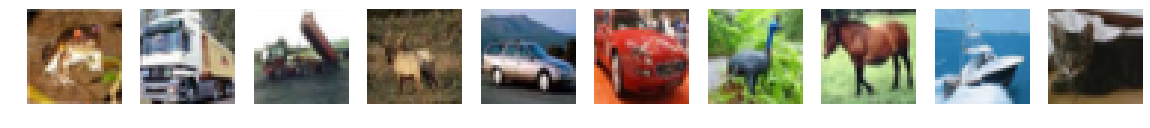

In [5]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')

In [6]:
# Convert y_train and y_test into one-hot labels
y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test, num_classes)

# Rescale X_train and X_test
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/255
X_test  = X_test/255

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


# Train model

In [7]:
def VGGNet(batchNorm_on, dropout_on, dropout_rates, input_shape=(32, 32, 3), classes=10):
    """
    Arguments:
    
    batchNorm_on -- boolean, with batch normalization layers or not
    dropout_on -- boolean, with dropout layers or not
    dropout_rates -- python list of float, defining the dropout_rate_cnn and dropout_rate_dense
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    # batch_norm_axis = -1 # axis=-1 represent normalize the last axis (channel) in (samples, width, height, channal).
    dropout_rate_cnn = dropout_rates[0]
    dropout_rate_dense = dropout_rates[1]

    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=X_input[0].shape)) # output: 30 x 30 x 64
    if batchNorm_on:
        model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu')) # output: 28 x 28 x 64
    if batchNorm_on:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2)) # output: 14 x 14 x 64
    if dropout_on:
        model.add(Dropout(dropout_rate_cnn))

    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu')) # output: 12 x 12 x 128
    if batchNorm_on:
        model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu')) # output: 10 x 10 x 128
    if batchNorm_on:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2)) # output: 5 x 5 x 128
    if dropout_on:
        model.add(Dropout(dropout_rate_cnn))

    model.add(Flatten()) # reshape feature map to 1d array

    model.add(Dense(units=1024,activation='relu'))
    if batchNorm_on:
        model.add(BatchNormalization())
    if dropout_on:
        model.add(Dropout(dropout_rate_dense))
    model.add(Dense(units=1024,activation='relu'))
    if batchNorm_on:
        model.add(BatchNormalization())
    if dropout_on:
        model.add(Dropout(dropout_rate_dense))
    model.add(Dense(units=classes,activation='softmax'))

    return model

In [8]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 50, 100, 150 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs
        data_augmentation: boolean

    # Returns
        lr (float32): learning rate
    """

    lr = 1e-3
    if epoch > 300:
        lr *= 1e-2
    elif epoch > 125:
        lr *= 5e-2
    elif epoch > 100:
        lr *= 2e-1

    print('Learning rate: ', lr)
    return lr

Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/150
Learning rate:  0.001
391/391 [==============================] - 13s 33ms/step - loss: 1.7800 - accuracy: 0.3883 - val_loss: 2.9135 - val_accuracy: 0.1957
Epoch 2/150
Learning rate:  0.001
391/391 [==============================] - 11s 27ms/step - loss: 1.3932 - accuracy: 0.5037 - val_loss: 1.4980 - val_accuracy: 0.4885
Epoch 3/150
Learning rate:  0.001
391/391 [==============================] - 10s 27ms/step - loss: 1.2253 - accuracy: 0.5671 - val_loss: 1.1485 - val_accuracy: 0.5992
Epoch 4/150
Learning rate:  0.001
391/391 [==============================] - 10s 27ms/step - loss: 1.1108 - accuracy: 0.6070 - val_loss: 1.0601 - val_accuracy: 0.6452
Epoch 5/150
Learning rate:  0.001
391/391 [==============================] - 11s 27ms/step - loss: 1.0255 - accuracy: 0.6369 - val_loss: 0.9948 - val_accuracy: 0.6508
Epoch 6/150
Learning rate:  0.001
391/391 [==============================] - 10s 27ms/step - loss: 0.9695 - 

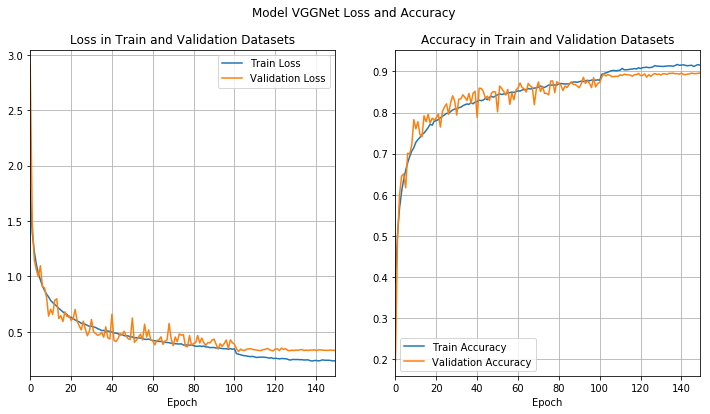

In [22]:
batchNorm_on = True
dropout_on = True
dropout_rates = [0.1, 0.1]
opt = Adam(learning_rate=lr_schedule(0)) #RMSprop(lr=0.001)
cnn_model = VGGNet(batchNorm_on, dropout_on, dropout_rates)
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

data_augmentation = True
batch_size = 128
epochs = 150
validation_data=(X_test, y_test)

# Prepare callbacks for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.2,
                               cooldown=0,
                               patience=20,
                               min_lr=0.5e-6,
                               verbose=1)

callbacks = [lr_scheduler]

if not data_augmentation:
    print('Not using data augmentation.')
    history = cnn_model.fit(X_train,y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=validation_data,
                            shuffle=True,
                            callbacks=callbacks)

else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        shear_range=0.2,  # set range for random shear
        zoom_range=0.2,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        fill_mode='nearest',  # set mode for filling points outside the input boundaries
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        rescale=None,  # set rescaling factor (applied before any other transformation)
        preprocessing_function=None,  # set function that will be applied on each input
        data_format=None,  # image data format, either "channels_first" or "channels_last"
        validation_split=0.0  # fraction of images reserved for validation (strictly between 0 and 1)
    )

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    history = cnn_model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                      epochs=epochs,
                                      validation_data=validation_data,
                                      max_queue_size=10,
                                      workers=8,
                                      callbacks=callbacks,
                                      use_multiprocessing=True
                                     )

plot_learning_curve(modelHistory = history, model_name = 'VGGNet')

# Model evaluation

Test Accuracy: 0.8960999846458435


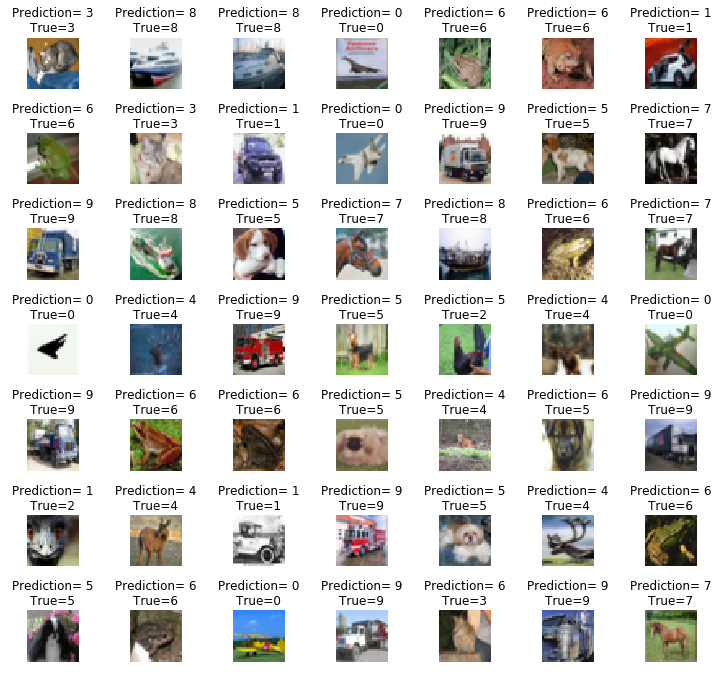

In [23]:
evaluation = cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: {}'.format(evaluation[1]))
predicted_classes = cnn_model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

y_test_num = y_test.argmax(1)

L=7
W=7
fig,axes = plt.subplots(L,W,figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction= {}\nTrue={}'.format(predicted_classes[i],y_test_num[i]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

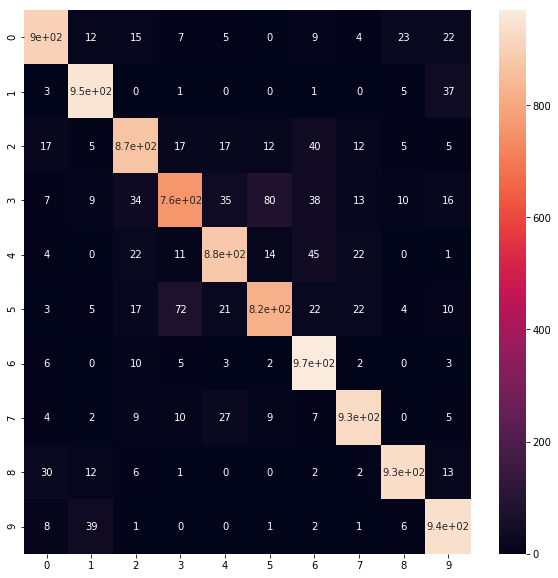

In [24]:
cm = confusion_matrix(y_test_num, predicted_classes)
cm
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True)
plt.ioff()

# Visualize feature maps

Input shape:  (50, 32, 32, 3)


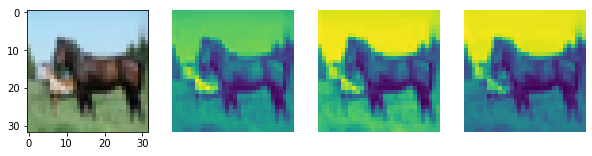

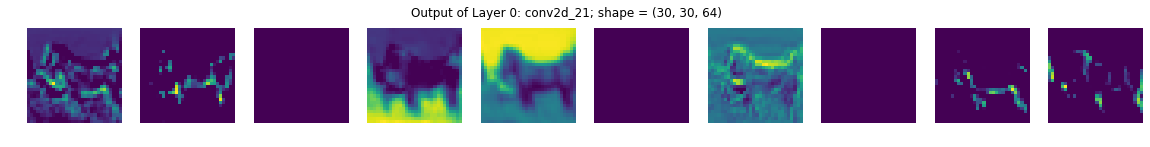

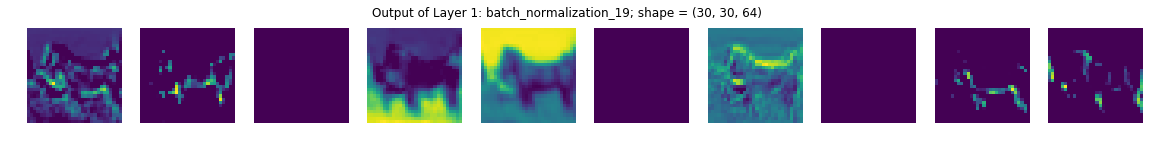

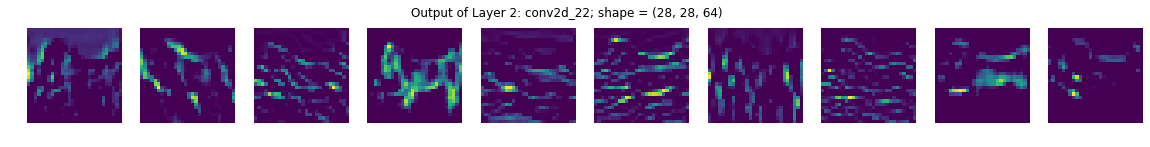

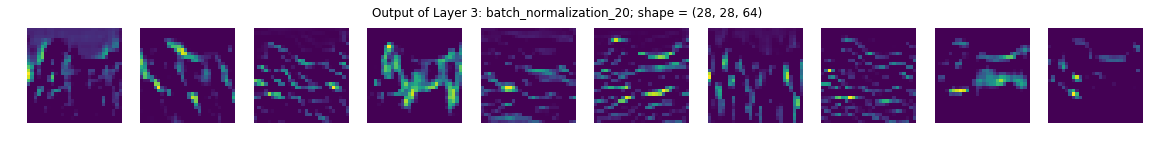

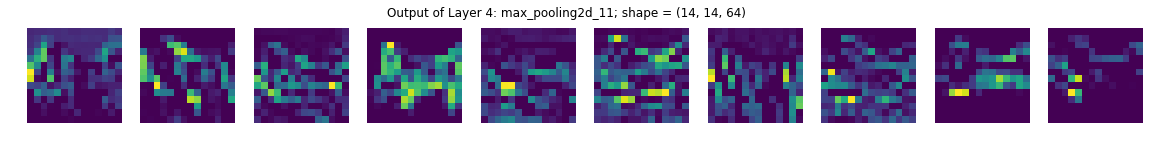

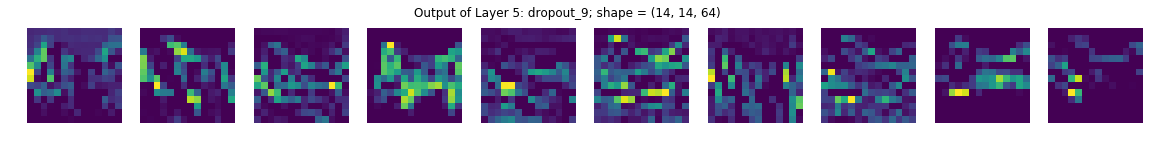

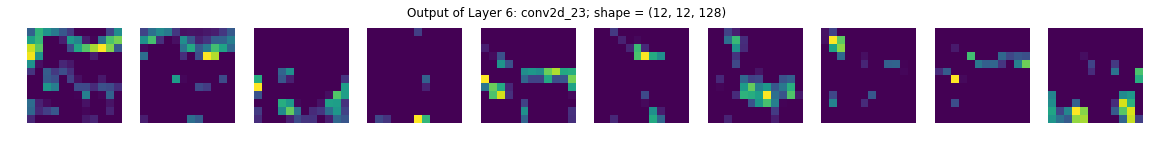

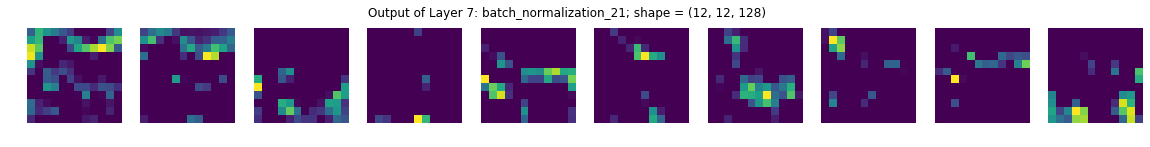

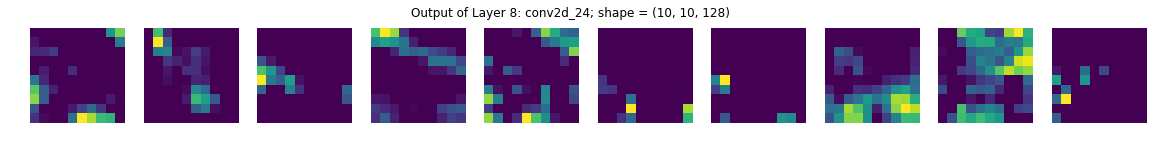

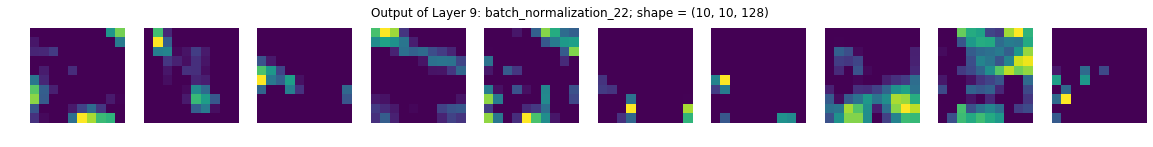

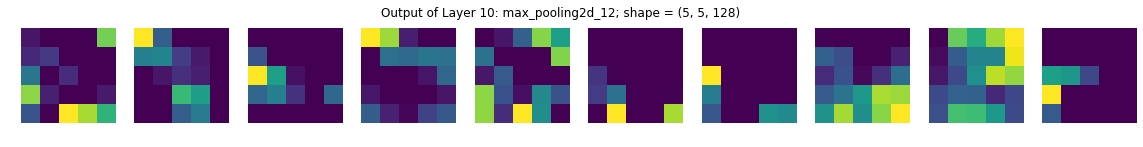

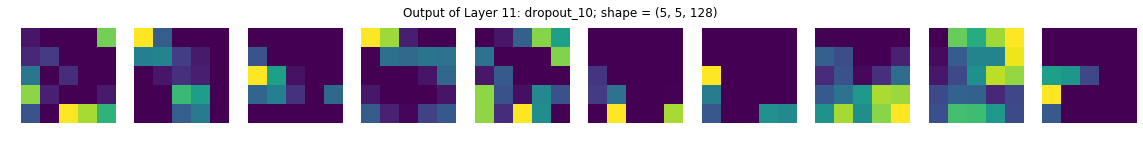

In [25]:
input_batch = 50
input_im = X_train[:input_batch, :, :, :]
input_show = 12
print('Input shape: ', input_im.shape)

# print input image:
plt.figure(figsize=(10, 3))
plt.subplot(1, 4, 1)
plt.imshow(X_train[input_show], interpolation='none')
for i in range(3):
    plt.subplot(1, 4, i+2)
    plt.imshow(X_train[input_show][:, :, i], cmap='viridis', interpolation='none')
    plt.axis('off')

# print feature maps
for layer_id in range(0, 12):
    intermediate_layer_model = Model(inputs=cnn_model.input, outputs=cnn_model.layers[layer_id].output)
    layer_output = intermediate_layer_model.predict(input_im)[input_show]
    plt.figure(figsize=(20, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(layer_output[:, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle('Output of Layer {}: '.format(layer_id) + cnn_model.layers[layer_id].name + '; shape = ' + str(layer_output.shape))

# Save model

In [ ]:
#import os 
#directory = os.path.join(os.getcwd(), 'saved_models')

#if not os.path.isdir(directory):
#    os.makedirs(directory)
#model_path = os.path.join(directory, 'keras_cifar10_trained_model.h5')
#cnn_model.save(model_path)

In [26]:
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_19 (Batc (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 128)      